In [19]:
import chess.pgn
import pandas as pd
import numpy as np

## Exemple de lecture d'une game

In [4]:
with open("game_data_2013_01.pgn") as pgn_file:
    game = chess.pgn.read_game(pgn_file)

print(game.headers)

Headers(Event='Rated Classical game', Site='https://lichess.org/j1dkb5dw', Date='????.??.??', Round='?', White='BFG9k', Black='mamalak', Result='1-0', UTCDate='2012.12.31', UTCTime='23:01:03', WhiteElo='1639', BlackElo='1403', WhiteRatingDiff='+5', BlackRatingDiff='-8', ECO='C00', Opening='French Defense: Normal Variation', TimeControl='600+8', Termination='Normal')


## Quelles features des metadatas sont à garder ?

- White
- Black
- Result
- UTCDate
- UTCTime
- WhiteElo
- BlackElo
- Opening
- TimeControl
- Termination

In [32]:
categories = ["White", "Black", "Result", "UTCDate", "UTCTime", "WhiteElo", "BlackElo", "ECO", "Opening", "TimeControl", "Termination"]
df = pd.DataFrame(columns=tuple(categories))
NUMB_GAMES = 1000

with open("game_data_2013_01.pgn") as pgn_file:
    n_game=1
    game = chess.pgn.read_game(pgn_file)
    while game and n_game < NUMB_GAMES :
        entry = {c:game.headers[c] for c in categories}
        df.loc[len(df)] = entry # only use with a RangeIndex!
        game = chess.pgn.read_game(pgn_file)
        n_game += 1

df.head(5)

,White,Black,Result,UTCDate,UTCTime,WhiteElo,BlackElo,ECO,Opening,TimeControl,Termination
0,BFG9k,mamalak,1-0,2012.12.31,23:01:03,1639,1403,C00,French Defense: Normal Variation,600+8,Normal
1,Desmond_Wilson,savinka59,1-0,2012.12.31,23:04:12,1654,1919,D04,"Queen's Pawn Game: Colle System, Anti-Colle",480+2,Normal
2,Kozakmamay007,VanillaShamanilla,1-0,2012.12.31,23:03:15,1643,1747,C50,Four Knights Game: Italian Variation,420+17,Normal
3,Naitero_Nagasaki,800,0-1,2012.12.31,23:04:57,1824,1973,B12,Caro-Kann Defense: Goldman Variation,60+1,Normal
4,nichiren1967,Naitero_Nagasaki,0-1,2012.12.31,23:02:37,1765,1815,C00,French Defense: La Bourdonnais Variation,60+1,Normal


In [38]:
### Conversion données

df[["White", "Black", "Result", "ECO",
    "Opening", "TimeControl", "Termination"]] = df[["White", "Black", "Result", "ECO",
                                                    "Opening", "TimeControl", "Termination"]].astype(str)

df.UTCDate = pd.to_datetime(df.UTCDate, format= '%Y.%m.%d')
df.UTCTime = pd.to_datetime(df.UTCTime, format= '%H:%M:%S').dt.time

df[["WhiteElo", "BlackElo"]] = df[["WhiteElo", "BlackElo"]].replace("?", np.nan)
df.WhiteElo = pd.to_numeric(df.WhiteElo, errors="coerce").astype("Int64")
df.BlackElo = pd.to_numeric(df.BlackElo, errors="coerce").astype("Int64")

df.head(5)

,White,Black,Result,UTCDate,UTCTime,WhiteElo,BlackElo,ECO,Opening,TimeControl,Termination
0,BFG9k,mamalak,1-0,2012-12-31,23:01:03,1639,1403,C00,French Defense: Normal Variation,600+8,Normal
1,Desmond_Wilson,savinka59,1-0,2012-12-31,23:04:12,1654,1919,D04,"Queen's Pawn Game: Colle System, Anti-Colle",480+2,Normal
2,Kozakmamay007,VanillaShamanilla,1-0,2012-12-31,23:03:15,1643,1747,C50,Four Knights Game: Italian Variation,420+17,Normal
3,Naitero_Nagasaki,800,0-1,2012-12-31,23:04:57,1824,1973,B12,Caro-Kann Defense: Goldman Variation,60+1,Normal
4,nichiren1967,Naitero_Nagasaki,0-1,2012-12-31,23:02:37,1765,1815,C00,French Defense: La Bourdonnais Variation,60+1,Normal


## Visualisation des données

In [6]:
import matplotlib.pyplot as plt

### ELO équilibrés ?

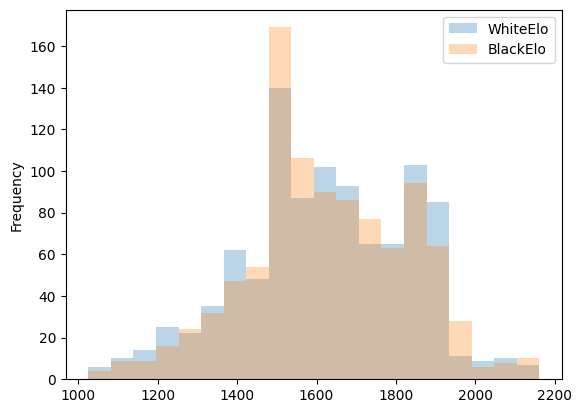

In [43]:
df[["WhiteElo","BlackElo"]].plot.hist(bins=20, alpha=0.3);

### Combien de gambits ?

In [47]:
df.Opening.str.contains("Gambit").sum()

np.int64(157)